PPP (with BM3D) CT Reconstruction (ADMM with CG Subproblem Solver)
==================================================================

This example demonstrates solution of a tomographic reconstruction problem
using the Plug-and-Play Priors framework
<cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

There are two versions of this example, solving the same problem in two
different ways. This version uses the data fidelity term as the ADMM $f$,
and thus the optimization with respect to the data fidelity uses CG rather
than the prox of the `SVMBIRSquaredL2Loss` functional, as in the
[other version](ct_svmbir_ppp_bm3d_admm_prox.rst).

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.xray.svmbir import SVMBIRSquaredL2Loss, XRayTransform
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.005], gap=2e-3, porosity=1.0), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = XRayTransform(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up an ADMM solver.

In [6]:
y = snp.array(y)
x0 = snp.array(x_mrf)
weights = snp.array(weights)

ρ = 15  # ADMM penalty parameter
σ = density * 0.18  # denoiser sigma

f = SVMBIRSquaredL2Loss(y=y, A=A, W=Diagonal(weights), scale=0.5)
g0 = σ * ρ * BM3D()
g1 = NonNegativeIndicator()

solver = ADMM(
    f=f,
    g_list=[g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 100}),
    itstat_options={"display": True, "period": 5},
)

Run the solver.

In [7]:
print(f"Solving on {device_info()}\n")
x_bm3d = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  6.98e+01  1.702e+00  6.097e+00     17  9.319e-05


   5  2.33e+02  2.571e-01  1.123e+00      8  9.575e-05


  10  3.06e+02  1.370e-01  4.564e-01      6  8.595e-05


  15  3.67e+02  1.123e-01  4.015e-01      6  9.391e-05


  19  4.14e+02  1.016e-01  3.705e-01      6  7.498e-05


Show the recovered image.

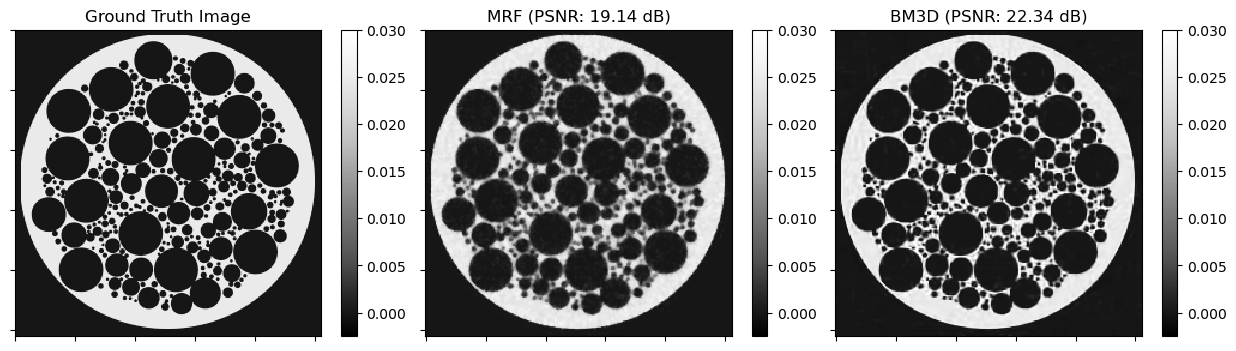

In [8]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_bm3d,
    title=f"BM3D (PSNR: {metric.psnr(x_gt, x_bm3d):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

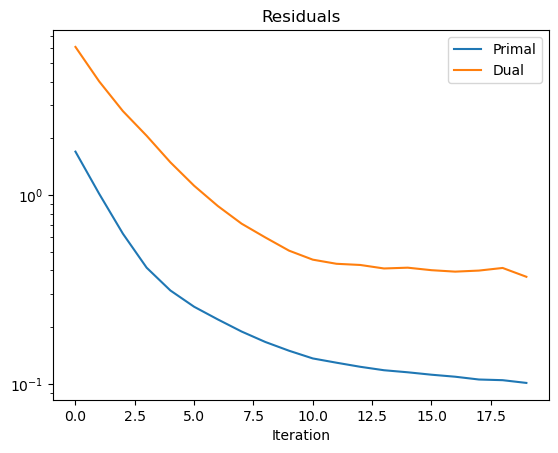

In [9]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)